In [1]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0],True)
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10171723293512993639
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4150263808
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18193847071514647239
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import seaborn as sn
import IPython
import music21

In [4]:
save_dir = "dataset/"
for file in os.listdir():
    if ".mid" in file:
        os.rename(file,save_dir+str(file))

In [5]:
def using_music21(midi_dir):
    notes = []
    for m in midi_dir:
        parsed = music21.converter.parse('dataset/'+m)
        notes_to_parse = None

        parts = music21.instrument.partitionByInstrument(parsed)
        if(parts): notes_to_parse = parts.parts[0].recurse()
        else: notes_to_parse = parsed.flat.notes

        for e in notes_to_parse:
            if isinstance(e, music21.note.Note):    
                notes.append(str(e.pitch))
            elif isinstance(e,music21.chord.Chord):
                notes.append('.'.join(str(s) for s in e.normalOrder))
    return notes

In [6]:
#print(os.listdir('dataset/'))
audio_df = using_music21(os.listdir('dataset/'))

In [7]:
print(len(audio_df))

4993


In [8]:
audio_df[:10]

['C2', 'E3', 'G3', 'C4', 'E4', 'G5', 'E3', 'G3', 'C4', 'E4']

In [9]:
#no. of unique notes
vocab = len(set(audio_df))
print(vocab)

153


In [10]:
Tx = 120

delete = len(audio_df)%Tx 
last = audio_df[-delete+1]
del audio_df[-delete:]

print(len(audio_df))

X = list()
Y = list()

for i in range(0, len(audio_df), Tx):
    X.append(audio_df[i:i+Tx])
    if(i==len(audio_df)-Tx): 
        Y.append(audio_df[i+1:])
        Y[-1].append(last)
    else: Y.append(audio_df[i+1:i+1+Tx])


4920


In [11]:
id_to_note = {i:j for i,j in enumerate(sorted(set(audio_df)))}
note_to_id = {j:i for i,j in enumerate(sorted(set(audio_df)))}

In [12]:
note_to_id

{'0': 0,
 '0.1': 1,
 '0.1.3.6.8': 2,
 '0.2': 3,
 '0.2.5.8': 4,
 '0.3': 5,
 '0.3.6.8': 6,
 '0.3.6.9': 7,
 '0.3.7': 8,
 '0.4': 9,
 '0.4.7': 10,
 '0.5': 11,
 '0.6': 12,
 '1': 13,
 '1.3': 14,
 '1.4.7.10': 15,
 '1.5': 16,
 '1.5.8': 17,
 '10': 18,
 '10.0': 19,
 '10.1': 20,
 '10.1.3': 21,
 '10.1.5': 22,
 '10.2.5': 23,
 '10.3': 24,
 '11': 25,
 '11.0': 26,
 '11.0.2.5.7': 27,
 '11.2': 28,
 '11.2.5': 29,
 '11.2.5.7': 30,
 '2': 31,
 '2.3': 32,
 '2.4': 33,
 '2.4.7.10': 34,
 '2.5': 35,
 '2.5.7': 36,
 '2.5.8.11': 37,
 '2.6': 38,
 '2.7': 39,
 '3': 40,
 '3.5': 41,
 '3.5.8': 42,
 '3.6': 43,
 '3.6.10': 44,
 '3.6.8': 45,
 '3.7': 46,
 '3.7.10': 47,
 '3.8': 48,
 '4': 49,
 '4.5': 50,
 '4.5.7.10.0': 51,
 '4.7': 52,
 '4.7.10.0': 53,
 '4.9': 54,
 '5': 55,
 '5.10': 56,
 '5.11': 57,
 '5.7': 58,
 '5.7.0': 59,
 '5.7.11': 60,
 '5.8': 61,
 '5.8.0': 62,
 '5.9': 63,
 '6.7': 64,
 '6.8': 65,
 '6.9': 66,
 '7': 67,
 '7.0': 68,
 '7.10': 69,
 '7.10.1.3': 70,
 '7.11': 71,
 '7.11.2': 72,
 '7.8': 73,
 '7.8.10.1.3': 74,
 '7.9': 

In [13]:
for i in range(len(X)):
    X[i] = [note_to_id[j] for j in X[i]]
    Y[i] = [note_to_id[j] for j in Y[i]]

In [14]:
x = tf.one_hot(X,vocab)
y = tf.one_hot(Y,vocab)

In [15]:
x.shape

TensorShape([41, 120, 153])

In [16]:
lstm = tf.keras.layers.LSTM(128, return_state = True)
reshape = tf.keras.layers.Reshape((1,vocab))
dense = tf.keras.layers.Dense(vocab, activation = tf.keras.activations.softmax)

In [17]:
def model(Tx,lstm,reshape,dense):

    input_x = tf.keras.layers.Input(shape=(Tx,dense.units))
    a0 = tf.keras.layers.Input(shape=(lstm.units,))
    c0 = tf.keras.layers.Input(shape=(lstm.units,))

    a = a0
    c = c0

    final_output = list()

    for time in range(Tx):
        x = input_x[:,time,:]
        x = reshape(x)
        a,_,c = lstm(x,initial_state=[a,c])
        output = dense(a)
        final_output.append(output)

    res = tf.keras.models.Model(inputs = [input_x,a0,c0], outputs = final_output, name='w1')

    return res

In [18]:
tf.keras.backend.clear_session()
w1 = model(Tx,lstm,reshape,dense)

In [19]:
len(w1.output_shape)

120

In [20]:
y_reshape = tf.reshape(y,(120,41,-1)).numpy()
y_reshape.shape

(120, 41, 153)

In [21]:
w1.summary()

Model: "w1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 153)]   0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 153)         0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 reshape (Reshape)              (None, 1, 153)       0           ['tf.__operators__.getitem[0][0]'
                                                                 , 'tf.__operators__.getitem_1[0][
                                                                 0]',                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.427126 to fit



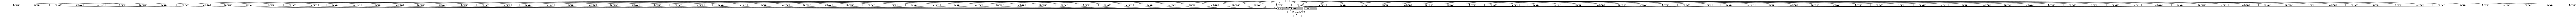

In [22]:
tf.keras.utils.plot_model(w1, show_shapes=True)

In [23]:
w1.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
a0 = np.zeros((41,128))
c0 = np.zeros((41,128))

In [25]:
history = w1.fit([x,a0,c0],list(y_reshape),epochs=10000,verbose=0)

loss at epoch 1: 603.43359375
loss at epoch 10000: 0.8408884406089783


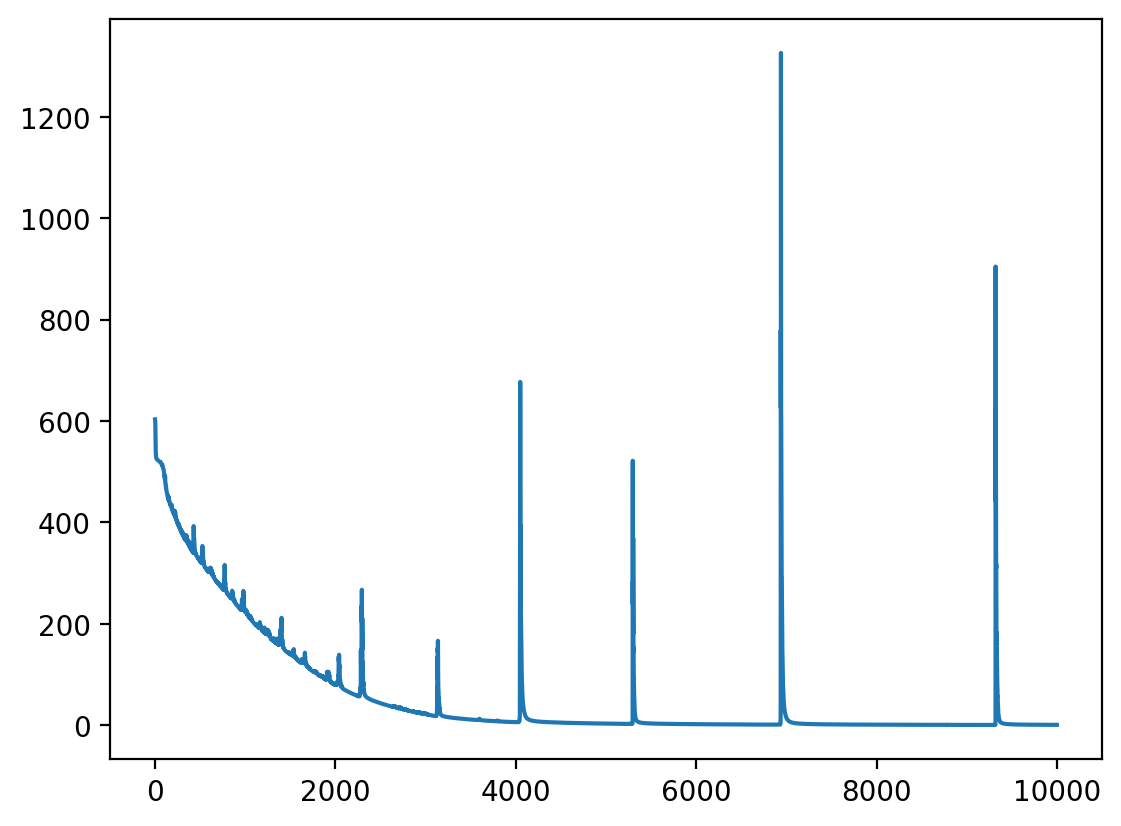

In [26]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 10000: {history.history['loss'][-1]}")
plt.plot(history.history['loss'])

tf.keras.models.save_model(w1,'w1_weights.hdf5')

In [27]:
def inference(Ty,lstm,dense):

    vocab = dense.units

    x0 = tf.keras.layers.Input((1,dense.units))
    a0 = tf.keras.layers.Input((lstm.units,))
    c0 = tf.keras.layers.Input((lstm.units,))

    x=x0
    a=a0
    c=c0

    outputs = list()

    for time in range(Ty):
        a,_,c = lstm(x,initial_state=[a,c])
        out = dense(a)
        outputs.append(out)
        #y[time-1] = x[t]
        x = tf.math.argmax(out,axis=-1)
        x = tf.one_hot(x,vocab)
        x = tf.keras.layers.RepeatVector(1)(x) #convert into layer type
    
    res = tf.keras.models.Model([x0,a0,c0],outputs)
    return res

In [28]:
w1_inference = inference(150,lstm,dense)
w1_inference.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1, 153)]     0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        144384      ['input_4[0][0]',                
                                 (None, 128),                     'input_5[0][0]',            

tf.keras.models.save_model(w1_inference,'w1_inference.hdf5')

In [29]:
x_inf = np.zeros((1,1,vocab))
a_inf = np.zeros((1,128))
c_inf = np.zeros((1,128))

In [34]:
def sampling(inference,x,a,c):
    pred = inference.predict([x,a,c])
    pred_indices = tf.argmax(pred,axis=-1)
    output = tf.keras.utils.to_categorical(pred_indices,num_classes=x.shape[-1])
    return output,pred_indices

In [35]:
output, pred_indices = sampling(w1_inference,x_inf,a_inf,c_inf)

In [47]:
indices = [id_to_note[i.numpy()[0]] for i in pred_indices]

In [49]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in indices:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = music21.note.Note(int(current_note))
            new_note.storedInstrument = music21.instrument.Piano()
            notes.append(new_note)
        new_chord = music21.chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = music21.note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = music21.instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [50]:
stream = music21.stream.Stream(output_notes)
stream.write('midi', fp='generated_music.mid')

'generated_music.mid'

In [52]:
IPython.display.Audio('generated_music.wav')